# Non-convex function optimization: Gradient-Based Methods and Black-Box Optimization

In this notebook I experiment with multiple Black-Box optimization (BBO) methods and check their behaviour and performance on non-convex function.

*Reference:* _The idea and visualisation functions are taken from Louis Tiao tutorial http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/_

In [2]:
from collections import defaultdict
from functools import partial
from itertools import zip_longest

from autograd import elementwise_grad, value_and_grad
import autograd.numpy as np
from IPython.display import HTML, display
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nevergrad as ng
from scipy.optimize import minimize
from turbo import Turbo1, TurboM

%matplotlib inline

## Animation Class implementations from the original notebook

In this part I collect animation classes from the original notebook. Furthermore, I wrap visualisation and animation code into functions that will facilitate results presentation in the later steps.



In [3]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(
        self, *paths, labels=None, fig=None, ax=None, frames=None, 
        interval=150, repeat_delay=5, blit=True, **kwargs,
    ):
        
        labels = labels if labels is not None else []

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(
            fig, self.animate, init_func=self.init_anim,
            frames=frames, interval=interval, blit=blit,
            repeat_delay=repeat_delay, **kwargs,
        )

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [4]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(
        self, *paths, zpaths, labels=None, fig=None, ax=None, 
        frames=None, interval=60, repeat_delay=5, blit=True, **kwargs,
    ):
        
        labels = labels if labels is not None else []

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=4)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(
            fig, self.animate, init_func=self.init_anim,
            frames=frames, interval=interval, blit=blit,
            repeat_delay=repeat_delay, **kwargs,
        )

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [5]:
def plot3d(x, y, z, minima=None, path=None, f=None, xlim=None, ylim=None):
    """Visualize function values in 3d space. Place marker at minima if provided.
    Plot path on top if provided.

    Parameters:
        x: np.ndarray - x values.
        y: np.ndarray - y values. 
        z: np.ndarray - z values. 
        minima: np.ndarray (optional) - global minima point. 
        path: np.ndarray (optional) - path to visualise on top of the plot. 
    """
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot_surface(
        x, y, z, 
        rstride=1, 
        cstride=1, 
        edgecolor='none', 
        alpha=.8, 
        cmap=plt.cm.jet,
    )

    if path is not None:
        ax.quiver(
            path[0,:-1], path[1,:-1], 
            f(*path[::,:-1]), 
            path[0,1:]-path[0,:-1], 
            path[1,1:]-path[1,:-1], 
            f(*(path[::,1:]-path[::,:-1])), 
            color='k',
        )

    if minima is not None:
        ax.plot(*minima, f(*minima), 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    plt.show()

def contour_plot(
        x, y, z, minima=None, path=None, f=None, xlim=None, ylim=None, vmax=14):
    """Plot contours of function values. Place marker at minima if provided.
    Plot path on top if provided.

    Parameters:
        x: np.ndarray - x values.
        y: np.ndarray - y values. 
        z: np.ndarray - z values. 
        minima: np.ndarray (optional) - global minima point. 
        path: np.ndarray (optional) - path to visualise on top of the plot. 
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(
        x, y, z, 
        levels=np.linspace(0, vmax, 20),
        cmap=plt.cm.jet,
    )

    if path is not None:
        ax.quiver(
            path[0,:-1], path[1,:-1], 
            path[0,1:]-path[0,:-1], 
            path[1,1:]-path[1,:-1], 
            scale_units='xy', 
            angles='xy', 
            scale=1, 
            color='k',
        )
    
    if minima is not None:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    plt.show()

In [6]:
def plot3d_animated(
        x, y, z, paths, minima=None, labels=None, f=None, xlim=None, ylim=None):
    """Visualize function values in 3d space. Place marker at minima if provided.
    Animate paths on top of the plot.

    Parameters:
        x: np.ndarray - x values.
        y: np.ndarray - y values. 
        z: np.ndarray - z values.
        paths: np.ndarray - path to animate on top of the plot.  
        minima: np.ndarray (optional) - global minima point. 
        labels: List[str] (optional) - legend labels.
    """
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot_surface(
        x, y, z, 
        rstride=1, 
        cstride=1, 
        edgecolor='none', 
        alpha=.8, 
        cmap=plt.cm.jet,
    )

    if minima is not None:
        ax.plot(*minima, f(*minima), 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    zpaths = [f(*path) for path in paths]
    anim = TrajectoryAnimation3D(
        *paths, 
        zpaths=zpaths, 
        labels=labels, 
        ax=ax,
        interval=200,
        repeat_delay=2,
    )

    ax.legend(loc='upper left')
    plt.close()
    display(HTML(anim.to_html5_video()))

def contour_plot_animated(
        x, y, z, paths, minima=None, labels=None, f=None, xlim=None, ylim=None, 
        vmax=14,
    ):
    """Plot contours of function values. Place marker at minima if provided.
    Animate paths on top of the plot.

    Parameters:
        x: np.ndarray - x values.
        y: np.ndarray - y values. 
        z: np.ndarray - z values.
        paths: np.ndarray - path to animate on top of the plot.  
        minima: np.ndarray (optional) - global minima point. 
        labels: List[str] (optional) - legend labels.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(
        x, y, z, 
        levels=np.linspace(0, vmax, 20), 
        cmap=plt.cm.jet,
    )

    if minima is not None:
        ax.plot(*minima, 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    anim = TrajectoryAnimation(
        *paths, 
        labels=labels, 
        ax=ax,
        interval=200,
        repeat_delay=2,
    )

    ax.legend(loc='upper left')
    plt.close()
    display(HTML(anim.to_html5_video()))

# How gradient-based methods behave on non-convex functions


The optimization methods will be tested on Ackley function selected from Wikipedia page with functions to test optimization methods.

\begin{equation}
f(x, y) = - 20 \exp{\left[-0.2 \sqrt{0.5\left(x^2 + y^2\right)}\right]} - \exp{\left[0.5(\cos2\pi x + \cos 2 \pi y)\right]} + e + 20
\end{equation}

In [7]:
# Define the objective function.
f  = lambda x, y: (
    -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) 
    - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
    + np.exp(1) + 20
)

In [8]:
# Define range and mesh step.
xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2

xlim = (xmin, xmax)
ylim = (ymin, ymax)
# Create meshgrids to compute function values.
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
# Compute function values.
z = f(x, y)

In [9]:
# Known global minima.
minima_ = np.array([0, 0]).reshape(-1, 1)
print(f(*minima_))

[0.]


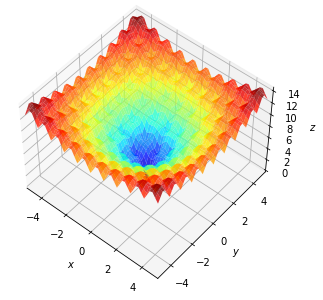

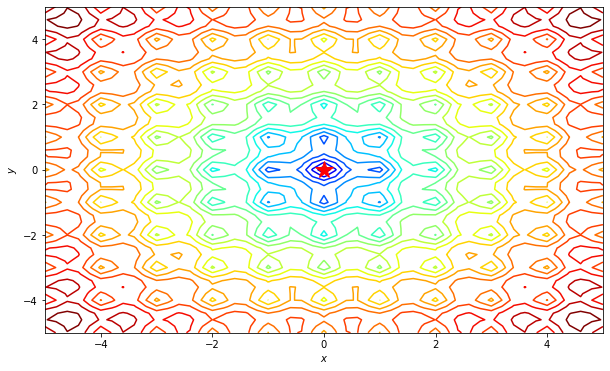

In [10]:
# Visualise the function and the minima point.
plot3d(x, y, z, minima_, f=f, xlim=xlim, ylim=ylim)
contour_plot(x, y, z, minima_, f=f, xlim=xlim, ylim=ylim)

Results of gradient-based method

In this part, gradient-based methods will be used to check how they behave on non-convex functions. The methods used here are taken from the original notebook and use `scipy.optimize` implementation.

In [11]:
x0 = np.array([-3.5, 3])
func = value_and_grad(lambda args: f(*args))

In [12]:
methods = [
    "CG",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
]

minimize_ = partial(
    minimize, 
    fun=func, 
    x0=x0,
    jac=True,
    bounds=[(xmin, xmax), (ymin, ymax)],
    tol=1e-20,
)
paths = defaultdict(lambda: [x0])
results = {
    method: minimize_(method=method, callback=paths[method].append) 
    for method in methods
}

paths_ = [np.array(paths[method]).T for method in methods]

for method in methods:
    print(method, "-", paths[method][-1])

CG - [-1.97445199  1.97445199]
Newton-CG - [-1.96461666  0.98241603]
L-BFGS-B - [ 6.63818646e-16 -9.13422150e-17]
TNC - [ 0.96847766 -0.96847766]
SLSQP - [ 0.96847766 -0.96847766]


/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [13]:
plot3d_animated(x, y, z, paths_, minima=minima_, labels=methods, f=f, xlim=xlim, ylim=ylim)
contour_plot_animated(x, y, z, paths_, minima=minima_, labels=methods, f=f, xlim=xlim, ylim=ylim)

It is visible and causes no surprise that gradient-based methods perform poorly on this kind of task because they are likely to get stuck in local minima what is well visible in case of `CG` and `Newton-CG`. Surprisingly enough, `L-BFGS-B` manages to reach the global minimum very efficiently. 

## Other optimization methods

### Nevergrad: https://facebookresearch.github.io/nevergrad/index.html

Here multiple optimization methods will be tested using the tool developed by researchers from Facebook. `RandomSearch` is used as a baseline. Because the process of the searching for a minima is very chaotic only the current best result is visualised as a path. That can be changes by setting `save_best_only=False`. In this case visualisation will show all the visited points.

In [14]:
# Initialize parameters to optimize. 
instrum = ng.p.Instrumentation(
    ng.p.Scalar(x0[0]).set_bounds(lower=xmin, upper=xmax), 
    ng.p.Scalar(x0[1]).set_bounds(lower=ymin, upper=ymax),
)

# Selection of optimization methods.
methods = (
    "NGOpt",
    "TwoPointsDE",
    "OnePlusOne",
    "RandomSearch",
)

paths = {}

# When set true saves only the recommendation, 
# otherwise save all the points visited by the optimizer.
save_best_only = True

for method in methods:
    # Initialize optimizer.
    optimizer = ng.optimizers.registry[method](
        parametrization=instrum, 
        budget=30, 
        num_workers=1,
    )
    path = []
    # Perform optimization.
    for _ in range(optimizer.budget):
        xx = optimizer.ask()
        loss = f(*xx.args)
        optimizer.tell(xx, loss)
        # Save best points to visualise the path.
        if save_best_only:
           path.append(optimizer.provide_recommendation().value[0])
        else:
            path.append(xx.args)
        # Save visited points to visualise the path.
    print(method, "-", optimizer.provide_recommendation().value[0])
    paths[method] = [x0] + path

paths_ = [np.array(paths[method]).T for method in methods]

NGOpt - (0.9505623396246952, -0.0007551945717709785)
TwoPointsDE - (1.0135829698074064, -0.8457225116082494)
OnePlusOne - (0.30804571779576634, -0.02579186038016834)
RandomSearch - (0.7025876900854957, -1.1693769294294807)


/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/nevergrad/optimization/differentialevolution.py:106: InefficientSettingsWarning: DE algorithms are inefficient with budget < 60
  warnings.warn(


In [15]:
plot3d_animated(x, y, z, paths_, minima=minima_, labels=methods, f=f, xlim=xlim, ylim=ylim)
contour_plot_animated(x, y, z, paths_, minima=minima_, labels=methods, f=f, xlim=xlim, ylim=ylim)

In this case, the optimizer didn't manage to reach the minima although the best results are not far from it. Proably allowing the algorithms to run for a longer time would bring better results. Surprisingly, `RandomSearch` managed to end up at almost optimal solution while the basic method `NGOpt` got stuct in a minima near the central region.

## Turbo https://github.com/uber-research/TuRBO

The implementation of algorithm form Scalable Global Optimization via Local Bayesian Optimization publication.

In [16]:
lb = np.array([xmin, ymin])
ub = np.array([xmax, ymax])
n_steps = 20

turbo1 = Turbo1(
    f=lambda x: f(*x),  # Handle to objective function
    lb=lb,  # Numpy array specifying lower bounds
    ub=ub,  # Numpy array specifying upper bounds
    n_init=4,  # Number of initial bounds from an Latin hypercube design
    max_evals=20,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=False,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

turbo_m = TurboM(
    f=lambda x: f(*x),  # Handle to objective function
    lb=lb,  # Numpy array specifying lower bounds
    ub=ub,  # Numpy array specifying upper bounds
    n_init=4,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=n_steps,  # Maximum number of evaluations
    n_trust_regions=4,  # Number of trust regions
    batch_size=1,  # How large batch size TuRBO uses
    verbose=False,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

turbo1.optimize()
turbo_m.optimize()

paths = [turbo1.X.T, turbo_m.X.T]

/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [17]:
plot3d_animated(x, y, z, paths, minima=minima_, labels=["turbo1", "turboM"], f=f, xlim=xlim, ylim=ylim)
contour_plot_animated(x, y, z, paths, minima=minima_, labels=["turbo1", "turboM"], f=f, xlim=xlim, ylim=ylim)

The algorithm based on local bayesian optimization performs pretty well and in case of `Turbo1` it reaches the area near gobal minima pretty fast and consinues a search in the local neighbourhood which appears to be the best strategy in this case.

## Test on Levi function

\begin{equation}
f(x,y)=\sin ^{2}3\pi x+\left(x-1\right)^{2}\left(1+\sin ^{2}3\pi y\right) + (y-1)^2 (1 + \sin^{2}2\pi y)
\end{equation}

In [18]:
f2 = lambda x, y: (
    np.sin(2 * np.pi * x) ** 2
    + ((x-1)**2) * (1 + np.sin(3 * np.pi * y)**2)
    + ((y-1)**2) * (1 + np.sin(2 * np.pi * y)**2)
)

# Define range and mesh step.
xmin2, xmax2, xstep2 = -7, 7, .2
ymin2, ymax2, ystep2 = -7, 7, .2
xlim2 = (xmin2, xmax2)
ylim2 = (ymin2, ymax2)
# Create meshgrids to compute function values.
x2, y2 = np.meshgrid(
    np.arange(xmin2, xmax2 + xstep2, xstep2), 
    np.arange(ymin2, ymax2 + ystep2, ystep2),
)
# Compute function values.
z2 = f2(x2, y2)
# Define global minima point. 
minima2_ = np.array([1, 1]).reshape(-1, 1)
print(f2(*minima2_))

[5.99903913e-32]


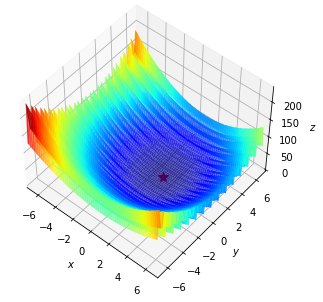

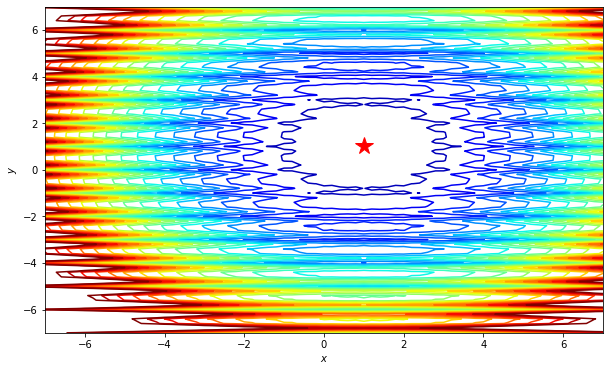

In [19]:
# Visualise the function and the minima point.
plot3d(x2, y2, z2, minima2_, f=f2, xlim=xlim2, ylim=ylim2)
contour_plot(x2, y2, z2, minima2_, f=f2, xlim=xlim2, ylim=ylim2, vmax=120)

## Gradient based methods

In [20]:
x0 = np.array([-6, 6])
func = value_and_grad(lambda args: f2(*args))

methods = [
    "CG",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
]

minimize_ = partial(
    minimize, 
    fun=func, 
    x0=x0,
    jac=True,
    bounds=[xlim2, ylim2],
    tol=1e-20,
)
paths = defaultdict(lambda: [x0])
results = {
    method: minimize_(method=method, callback=paths[method].append) 
    for method in methods
}

paths_ = [np.array(paths[method]).T for method in methods]

for method in methods:
    print(method, "-", paths[method][-1])

plot3d_animated(x2, y2, z2, paths_, minima=minima2_, labels=methods, f=f2, xlim=xlim2, ylim=ylim2)
contour_plot_animated(x2, y2, z2, paths_, minima=minima2_, labels=methods, f=f2, xlim=xlim2, ylim=ylim2, vmax=120)

/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/pawel/miniconda3/envs/optimization/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


CG - [1.94900323 3.48464583]
Newton-CG - [1.48757209 5.99502716]
L-BFGS-B - [1. 1.]
TNC - [1.         5.99492018]
SLSQP - [1. 1.]


Two of the gradient based methods managed to find global minima while the rest got stuck in local minimas. The fact that global minima was found by the gradient based methods is interesting. It might be caused by the fact that the methods take steps that are bigger than local periodicity of the function. Hence, the local minimas are over jumped by the methods.


## Nevergrad

In [21]:
# Initialize parameters to optimize. 
instrum = ng.p.Instrumentation(
    ng.p.Scalar(x0[0]).set_bounds(lower=xmin2, upper=xmax2), 
    ng.p.Scalar(x0[1]).set_bounds(lower=ymin2, upper=ymax2),
)

# Selection of optimization methods.
methods = (
    "NGOpt",
    "TwoPointsDE",
    "OnePlusOne",
    "RandomSearch",
)

paths = {}

# When set true saves only the recommendation, 
# otherwise save all the points visited by the optimizer.
save_best_only = True
n_steps = 100

for method in methods:
    # Initialize optimizer.
    optimizer = ng.optimizers.registry[method](
        parametrization=instrum, 
        budget=n_steps, 
        num_workers=1,
    )
    path = []
    # Perform optimization.
    for _ in range(optimizer.budget):
        xx = optimizer.ask()
        loss = f2(*xx.args)
        optimizer.tell(xx, loss)
        # Save best points to visualise the path.
        if save_best_only:
            path.append(optimizer.provide_recommendation().value[0])
        else:
            path.append(xx.args)
        # Save visited points to visualise the path.
    print(method, "-", optimizer.provide_recommendation().value[0])
    paths[method] = [x0] + path

paths_ = [np.array(paths[method]).T for method in methods]

plot3d_animated(
    x2, y2, z2, paths_, minima=minima2_, 
    labels=methods, f=f2, xlim=xlim2, ylim=ylim2,
)
contour_plot_animated(
    x2, y2, z2, paths_, minima=minima2_, 
    labels=methods, f=f2, xlim=xlim2, ylim=ylim2, vmax=120,
)

NGOpt - (-4.115191553707366, 4.998435511756572)
TwoPointsDE - (-0.021170430620937708, 1.5905631087652221)
OnePlusOne - (0.5134336201191482, 0.9990789041008759)
RandomSearch - (1.0091942578289306, 1.9147038193426802)


With the increased number of iterations allowes the Nevergrad methods manage to find global minima or it's close proximity pretty easily. However, the default method "NGOpt" got stuck in local minima and doesn't seem to be able to leave it's area.

## Turbo

In [22]:
lb = np.array([xmin2, ymin2])
ub = np.array([xmax2, ymax2])
n_steps = 30

turbo1 = Turbo1(
    f=lambda x: f2(*x),  # Handle to objective function
    lb=lb,  # Numpy array specifying lower bounds
    ub=ub,  # Numpy array specifying upper bounds
    n_init=4,  # Number of initial bounds from an Latin hypercube design
    max_evals=20,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=False,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

turbo_m = TurboM(
    f=lambda x: f2(*x),  # Handle to objective function
    lb=lb,  # Numpy array specifying lower bounds
    ub=ub,  # Numpy array specifying upper bounds
    n_init=4,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=n_steps,  # Maximum number of evaluations
    n_trust_regions=4,  # Number of trust regions
    batch_size=1,  # How large batch size TuRBO uses
    verbose=False,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

turbo1.optimize()
turbo_m.optimize()

paths = [turbo1.X.T, turbo_m.X.T]

plot3d_animated(
    x2, y2, z2, paths, minima=minima2_, 
    labels=methods, f=f2, xlim=xlim2, ylim=ylim2,
)
contour_plot_animated(
    x2, y2, z2, paths, minima=minima2_, 
    labels=methods, f=f2, xlim=xlim2, ylim=ylim2, vmax=120,
)

In this case global minima is found fairly easily however the algorithm keeps searching in other areas so the visualisation looks pretty chaotic.
